# Model Training


### Feature Engineering

#### Steps 
* Exploring Features of the dataset
* Handling Missing Values
* Feature Engineering
* Feature Selection 

#### Importing Packages and Libarires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)


# Create Dataframe
df = pd.read_csv("Cleaned_Hotel_boooking.csv")

# Print shape of dataset
print(df.shape)

(119210, 31)


# Data Cleaning and Data Transformation

#### Feature Extraction

* **Making new column named Total guests which is total visitors count**

* **By doing this we also reducing the number of attributes in a dataset while keeping as much of the variation in the original dataset as possible**

In [2]:
# Making single guests coloumn which includes childern, Adult and babies counts

df['total_guests'] = df['children'] + df['adults'] + df['babies'] # 3+2+2 = 7

In [3]:
# dropping children, adult, babies

df.drop(['children','adults','babies'],axis= 1, inplace= True)

## Other Data Manipulation

* **Change the lead time from hours to days and rounding it off with 2 decimal points**

In [4]:
df['lead_time'].value_counts

<bound method IndexOpsMixin.value_counts of 0         342
1         737
2           7
3          13
4          14
         ... 
119205     23
119206    102
119207     34
119208    109
119209    205
Name: lead_time, Length: 119210, dtype: int64>

In [5]:
df['lead_time'] = (df['lead_time']/24).round(2)

In [6]:
df['lead_time'].value_counts

<bound method IndexOpsMixin.value_counts of 0         14.25
1         30.71
2          0.29
3          0.54
4          0.58
          ...  
119205     0.96
119206     4.25
119207     1.42
119208     4.54
119209     8.54
Name: lead_time, Length: 119210, dtype: float64>

* **Manual encoding hotels type and month coloum**

* **Handling the imbalance data**

In [7]:
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df['reserved_room_type'] = df['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'L': 8})

* **Replacing and remove Undefined features**

In [8]:
df['market_segment'].value_counts

<bound method IndexOpsMixin.value_counts of 0                Direct
1                Direct
2                Direct
3             Corporate
4             Online TA
              ...      
119205    Offline TA/TO
119206        Online TA
119207        Online TA
119208        Online TA
119209        Online TA
Name: market_segment, Length: 119210, dtype: object>

In [9]:
# Replacing the Undefined column to self catring (SC)

df['meal'].replace("Undefined", "SC", inplace= True)

# Replace in market segment also

df['market_segment'].replace('Undefined', 'Online TA', inplace= True)

df.drop(df[df['distribution_channel']== 'Undefined'].index, inplace= True, axis= 0)

In [10]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_guests'],
      dtype='object')

* **Based on the in-sights from EDA, we drop the coloumn which are not important to target feature**

In [11]:
df.drop(columns=['arrival_date_week_number',"reservation_status","reservation_status_date",
                 "assigned_room_type",'agent','required_car_parking_spaces', 'is_repeated_guest'], inplace=True, axis=1)

#### Type of Features

* **Numerical Features**

In [12]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

print("Num of num features :", len(num_features))

Num of num features : 16


* **Catagorical Features**

In [13]:
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']

print("Num of cat features :", len(cat_features))

Num of cat features : 6


* **Discrete Features**

In [14]:
discrete_features = [feature for feature in num_features if len(df[feature].unique())<=25]

print("Num of dis features :", len(discrete_features))

Num of dis features : 10


In [15]:
year_features=[feature for feature in df.columns if 'date' in feature or 'month' in feature]

print('Num of Year Features :',len(year_features))

Num of Year Features : 3


* **Continues Features**

In [16]:
continues_feature = [feature for feature in num_features if feature not in discrete_features+year_features]

print('Num of contiues Features :',len(continues_feature))

Num of contiues Features : 5


### Feature Selection

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

Variance Inflation Factor(VIF) is a statistical measure used to access multicollinearity in regression analysis.
Multicollinearity occurs when two or more independent variable in a regression model are highly correlated with each other, which can cause problems in interpreting the results.

The VIF measures the degree of multicollinearity by quantifying how much the variance of the estimated regression coefficient is inflated comapred to what it would be if that variable were uncorrelated with other indepedent variable in the model.
Specifically, the VIF for a particular independent variable is calcualted as the ratio of the variance of the estimated coefficient to the variance of the coefficient when there is no multicollinearity.

Mathematically, the vif for the i-th variable can be calcualted as:

VIF_i = 1 / ( 1 - R_i^2)

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_feature, df):
    
    X = df[considered_feature]
    # the calcualtion of variance inflation requires a constant
    X['intercept'] = 1
    
    #create dataframe to store vif values
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!= 'intercept']
    return vif


In [18]:
compute_vif(num_features, df)

,Variable,VIF
0,hotel,1.210034
1,is_canceled,1.213572
2,lead_time,1.272711
3,arrival_date_year,1.612115
4,arrival_date_month,1.546312
5,arrival_date_day_of_month,1.005525
6,stays_in_weekend_nights,1.345136
7,stays_in_week_nights,1.423576
8,previous_cancellations,1.067876
9,previous_bookings_not_canceled,1.054083


* All the VIF values are relatively close to 1, which suggest that the variable are not highly correlated with each other.

**NOTE :**
* VIF values below 1.5, the variables in your model can be considered to have minimal multicollinearilty.
* VIF values above 1.5 as indicative of multicollinearilty, while others may use a higher thershold, such as 2 or 2.5 --> in banking and finance Domain.

## Outlier Removal and Checking the Skewness

* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule. IQR = Q3 - Q1

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

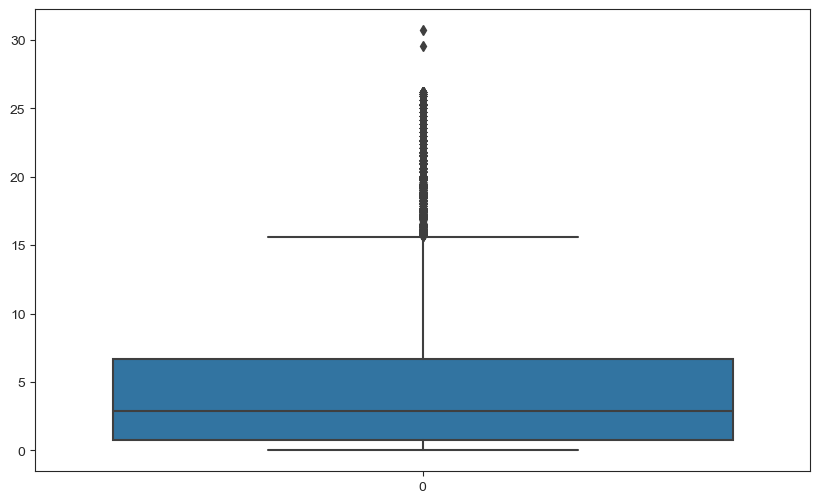

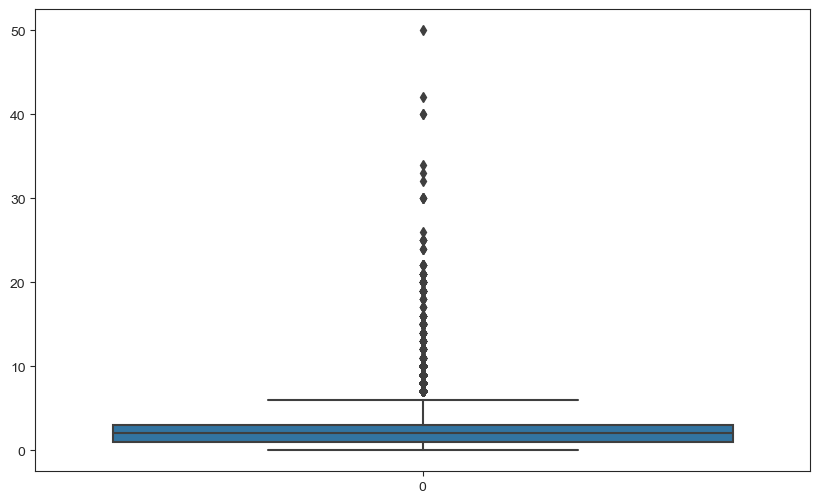

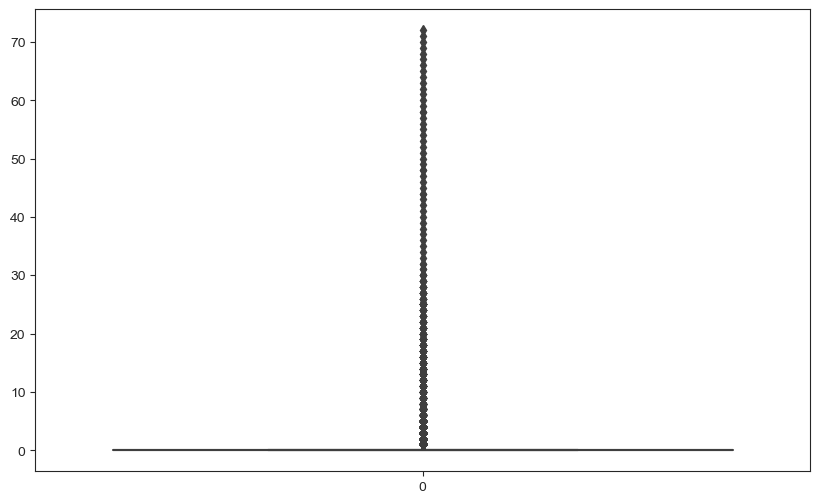

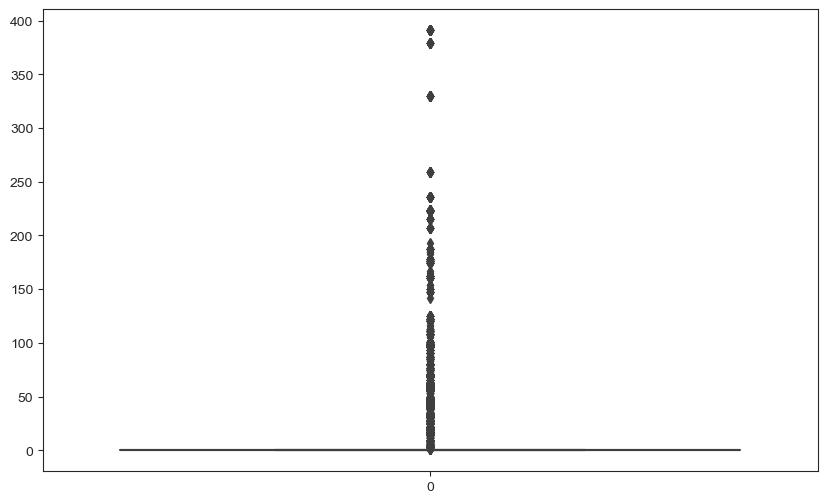

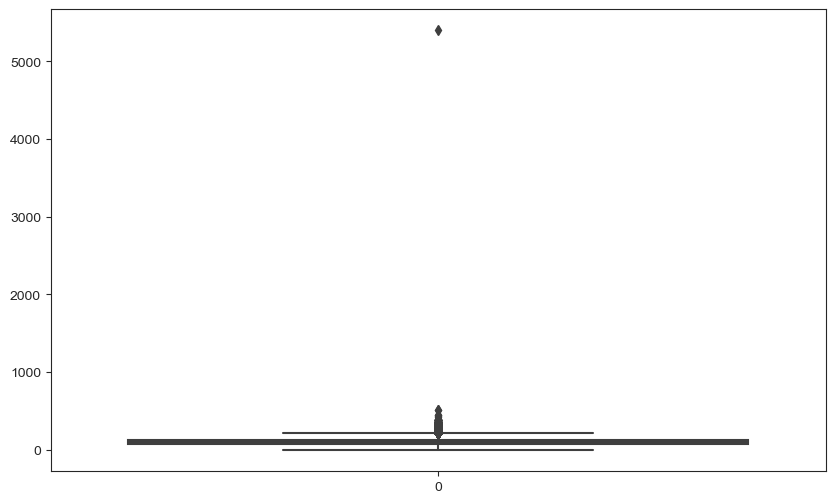

In [19]:
for i in continues_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [20]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    
    print('\n -----', col, '-----')
    
    print('percentile25', percentile25)
    print('percentile75', percentile75)
    
    iqr = percentile75 - percentile25 # IQR = Q3 - Q1
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    print('Upper Limit', upper_limit)
    print('Lower Limit', lower_limit)
    
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit

    return df

In [21]:
for col in continues_feature:
    detect_outliers(col)


 ----- lead_time -----
percentile25 0.75
percentile75 6.71
Upper Limit 15.649999999999999
Lower Limit -8.19

 ----- stays_in_week_nights -----
percentile25 1.0
percentile75 3.0
Upper Limit 6.0
Lower Limit -2.0

 ----- previous_bookings_not_canceled -----
percentile25 0.0
percentile75 0.0
Upper Limit 0.0
Lower Limit 0.0

 ----- days_in_waiting_list -----
percentile25 0.0
percentile75 0.0
Upper Limit 0.0
Lower Limit 0.0

 ----- adr -----
percentile25 69.5
percentile75 126.0
Upper Limit 210.75
Lower Limit -15.25


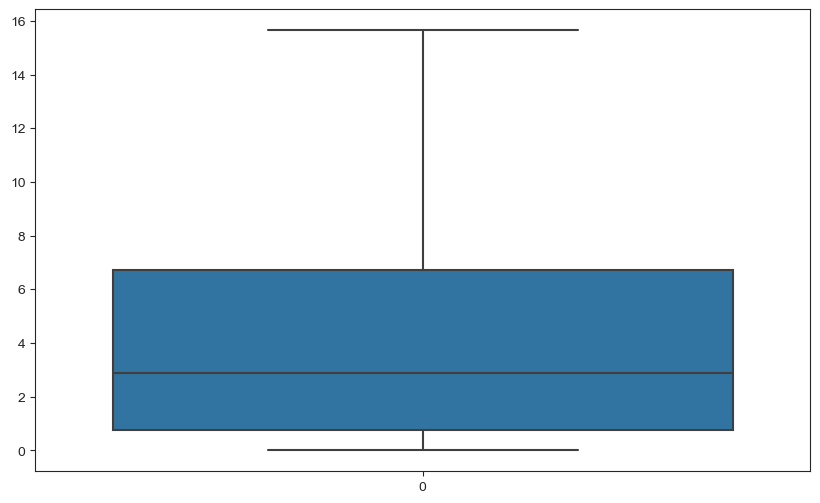

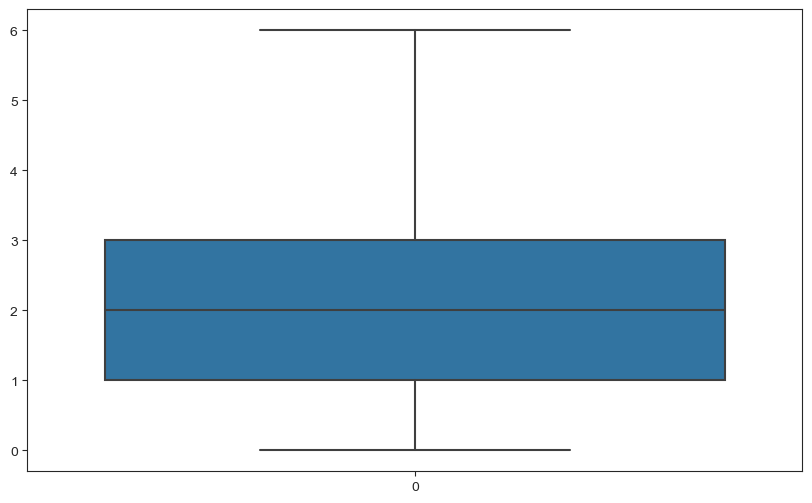

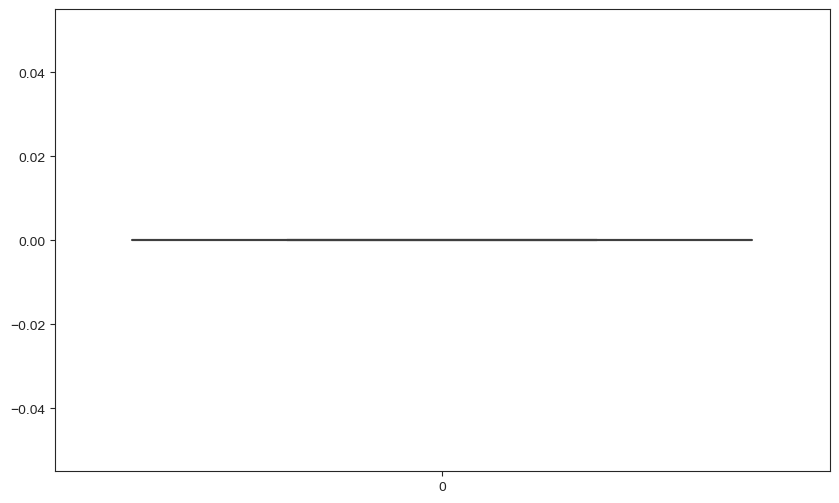

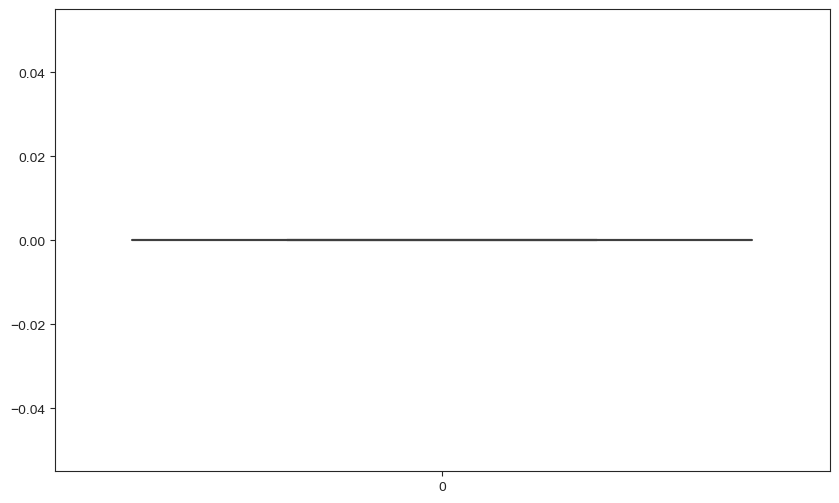

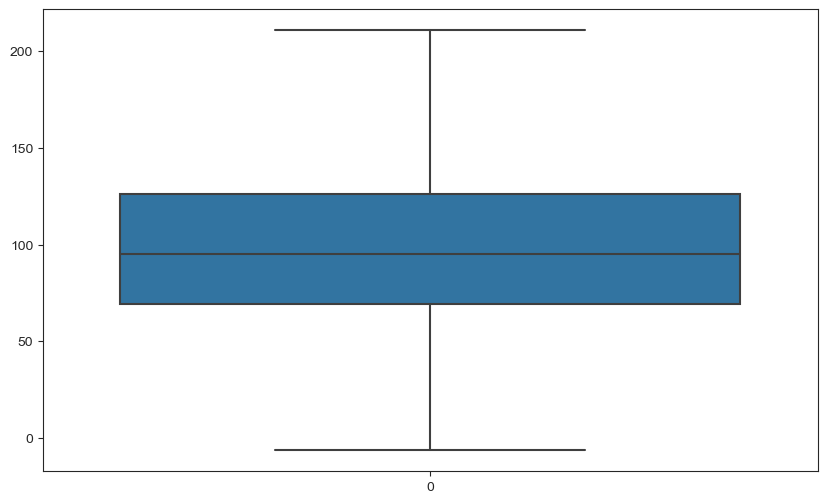

In [22]:
for i in continues_feature:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [23]:
df.drop(['previous_bookings_not_canceled', 'days_in_waiting_list'], inplace=True, axis=1)

* **Check Distribution of Lead Time coloumn**

Text(0, 0.5, 'Density')

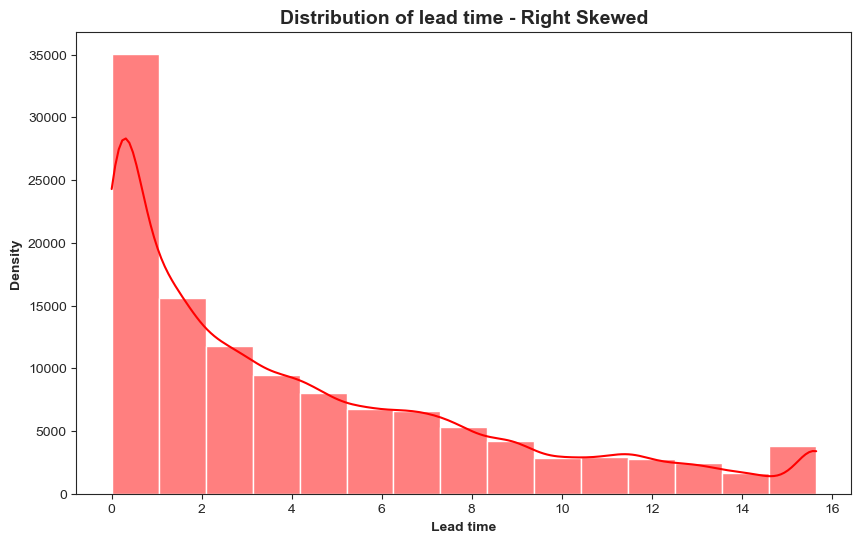

In [24]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
sns.histplot(df['lead_time'], bins= 15, color= 'r', kde= True)
plt.title('Distribution of lead time - Right Skewed', fontsize= 14, weight= 'bold')
plt.xlabel('Lead time', weight= 'bold')
plt.ylabel('Density', weight= 'bold')

In [25]:
df[['lead_time']] = df[['lead_time']].apply(np.log1p) # Log Transformation to reduce the skewness of our data

Text(0, 0.5, 'Density')

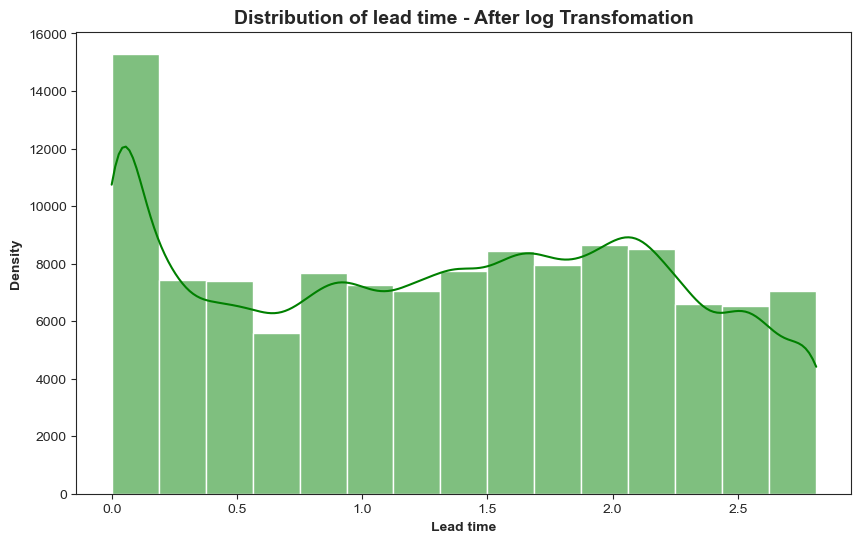

In [26]:
plt.figure(figsize=(10,6))
sns.set_style('ticks')
sns.histplot(df['lead_time'], bins= 15, color= 'g', kde= True)
plt.title('Distribution of lead time - After log Transfomation', fontsize= 14, weight= 'bold')
plt.xlabel('Lead time', weight= 'bold')
plt.ylabel('Density', weight= 'bold')

In [27]:
df.dropna(inplace=True)

### DataFrame Split


* **Split Dataframe to X and y**

* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “is_canceled” column.**

In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(['is_canceled'], axis=1)
y = df['is_canceled']

* **Save this list of countries to use it in the app**

In [29]:
import pickle #Convert country code into the country name
countries = list(X.country.unique())
with open('countryname.pkl', 'wb') as handle:
    pickle.dump(countries, handle)

* **Check all the coloumn which are in Train data set**

In [30]:
all_coloumn = list(X.columns)
print(all_coloumn)
len(all_coloumn)

['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'meal', 'country', 'market_segment', 'distribution_channel', 'previous_cancellations', 'reserved_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'total_of_special_requests', 'total_guests']


19

#### Feature Encoding

* **Extracting catgorical features from train set for feature encoding**

In [31]:
cat_features = [feature for feature in X.columns if X[feature].dtype == 'O']

print('No. of cat_features :', len(cat_features))

No. of cat_features : 6


* **Checking for unique variables in each coloumn**


In [32]:
for feature in cat_features:
    print(feature,":", X[feature].nunique())

meal : 4
country : 177
market_segment : 7
distribution_channel : 4
deposit_type : 3
customer_type : 4


### Pipeline for DataTransformation

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**

* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.


**Binary Encoder is used for Country which had 170 unique values**
* Binary encoding is a combination of Hash encoding and one-hot encoding. In this encoding scheme, the categorical feature is first converted into numerical using an ordinal encoder. Then the numbers are transformed in the binary number. After that binary value is split into different columns.

* Binary encoding works really well when there are a high number of categories, Like Countries in our case

In [ ]:
#!pip install category.encoders

In [33]:
# create coloumn Transformer with 3 types of transformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders.binary import BinaryEncoder
num_features = [feature for feature in X.columns if X[feature].dtype != 'O']
oh_columns = ['meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
bin_columns = ['country']

numeric_transformer = StandardScaler() # Standarzie all data in one format
bin_transformer = BinaryEncoder()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('binary', bin_transformer, bin_columns),
        ('oh', oh_transformer, oh_columns),
        ('num', numeric_transformer, num_features)
    ]
)

In [34]:
# Apply coloumn Transformer

X = preprocessor.fit_transform(X)

In [35]:
X

array([[ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.26278444,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ..., -0.57895841,
        -0.72076524, -1.35098757],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.27796495,
         4.32423173,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0811014 ,
        -0.72076524,  0.040073  ],
       [ 0.        ,  0.        ,  0.        , ...,  1.13180885,
         1.80173324,  0.040073  ]])

In [36]:
import pickle
pickle.dump(preprocessor, open('preprocess.pkl', 'wb'))

## Train Test Split

In [37]:
# Separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=40)

X_train.shape, X_test.shape

((89403, 43), (29802, 43))

## Model Selection

* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score,f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [39]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Navie Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logisitic Regression": LogisticRegression(),
    "K-Neighbours Classifier": KNeighborsClassifier(),
    "XGBClassifer": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier() 
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # train model
    
    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calcualting the accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calcualting f1 score
    model_train_precision = precision_score(y_train, y_train_pred) # Calcualting Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calcualting recall 
    
    # Testing set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calcualting the accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calcualting f1 score
    model_test_precision = precision_score(y_test, y_test_pred) # Calcualting Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calcualting recall 
    
    print(list(models.keys())[i])
    
        
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    
    print('='*35)
    print('\n')
    

Random Forest
Model performance for Training set
- Accuracy: 0.9956
- F1 score: 0.9956
- Precision: 0.9946
- Recall: 0.9935
----------------------------------
Model performance for Test set
- Accuracy: 0.8822
- F1 score: 0.8811
- Precision: 0.8688
- Recall: 0.7996


Navie Bayes
Model performance for Training set
- Accuracy: 0.7749
- F1 score: 0.7554
- Precision: 0.8594
- Recall: 0.4721
----------------------------------
Model performance for Test set
- Accuracy: 0.7807
- F1 score: 0.7622
- Precision: 0.8593
- Recall: 0.4810


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8365
- F1 score: 0.8331
- Precision: 0.8338
- Recall: 0.7002
----------------------------------
Model performance for Test set
- Accuracy: 0.8355
- F1 score: 0.8322
- Precision: 0.8255
- Recall: 0.6993


Logisitic Regression
Model performance for Training set
- Accuracy: 0.8033
- F1 score: 0.7971
- Precision: 0.8028
- Recall: 0.6247
----------------------------------
Model performance for Test set


### Hyper Parameter Tuning

In [40]:
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8, 12, 20, 30]}

In [41]:
randomcv_models = [('KNN', KNeighborsClassifier(), knn_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(), xgboost_params),
                   ('CatBoost', CatBoostClassifier(verbose=False), cat_params)
                   ]

In [42]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    rf_random = RandomizedSearchCV(estimator= model,
                                   param_distributions= params,
                                   n_iter=100,
                                   cv= 3,
                                   verbose= 2,
                                   n_jobs= -1)
    rf_random.fit(X_train, y_train)
    model_param[name] = rf_random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---------------- Best Params for KNN -------------------
{'n_neighbors': 10}
---------------- Best Params for RF -------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 8, 'max_depth': None}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.4}
---------------- Best Params for CatBoost -------------------
{'max_depth': 12, 'learning_rate': 0.1}


### Models Re-Trained with best Parameters

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

models = {
    "Random Forest": RandomForestClassifier(n_estimators= 1000, min_samples_split= 2, max_features= 8, max_depth=None),
    "K-Neighbors Classifer": KNeighborsClassifier(n_neighbors= 10),
    "XGBClassifier": XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs= -1),
    "CatBoost Classifer": CatBoostClassifier(max_depth= 12, learning_rate= 0.1, verbose=False)
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Again train the model
    
    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc



    print(list(models.keys())[i])
   
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9956
- F1 score: 0.9956
- Precision: 0.9950
- Recall: 0.9932
- Roc Auc Score: 0.9951
----------------------------------
Model performance for Test set
- Accuracy: 0.8841
- F1 score: 0.8830
- Precision: 0.8695
- Recall: 0.8047
- Roc Auc Score: 0.8674


K-Neighbors Classifer
Model performance for Training set
- Accuracy: 0.8641
- F1 score: 0.8610
- Precision: 0.8812
- Recall: 0.7335
- Roc Auc Score: 0.8374
----------------------------------
Model performance for Test set
- Accuracy: 0.8367
- F1 score: 0.8334
- Precision: 0.8271
- Recall: 0.7013
- Roc Auc Score: 0.8082


XGBClassifier
Model performance for Training set
- Accuracy: 0.9731
- F1 score: 0.9730
- Precision: 0.9737
- Recall: 0.9535
- Roc Auc Score: 0.9691
----------------------------------
Model performance for Test set
- Accuracy: 0.8806
- F1 score: 0.8796
- Precision: 0.8615
- Recall: 0.8036
- Roc Auc Score: 0.8644


CatBoost Classifer
Model performance for Traini

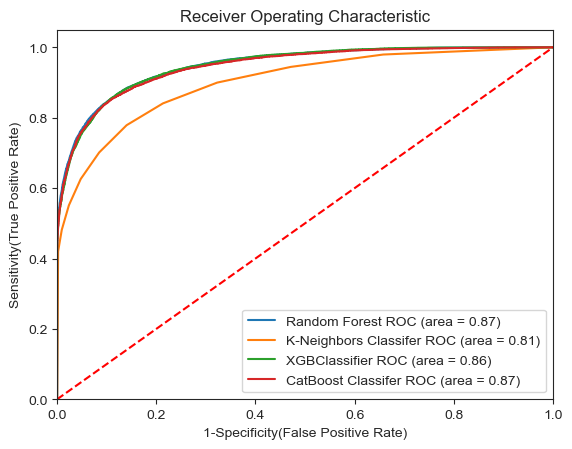

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_model = [
    {
        'label' : 'Random Forest',
        'model' : RandomForestClassifier(n_estimators= 1000, min_samples_split= 2, max_features= 8, max_depth=None),
        'auc'   : 0.8674
    },
    {
        'label' : 'K-Neighbors Classifer',
        'model' : KNeighborsClassifier(n_neighbors= 10),
        'auc'   : 0.8082
    },
    {
       'label' : 'XGBClassifier',
       'model' :  XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs= -1),
        'auc'  : 0.8644
    },
    {
        'label' : 'CatBoost Classifer',
        'model' : CatBoostClassifier(max_depth= 12, learning_rate= 0.1, verbose=False),
        'auc'   : 0.8670
    }
]

# Below for loop iterates through your model list

for m in auc_model:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train your model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], m['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('auc.png')
plt.show()   # Display

### Feature Selection for Model Deployment


In [50]:
best_xgb = XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 0.4, n_jobs=-1)
best_xgb = best_xgb.fit(X_train,y_train)
xgb_pred = best_xgb.predict(X_test)
score = accuracy_score(y_test,xgb_pred)
cr = classification_report(y_test,xgb_pred)

print("FINAL XGB")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL XGB
Accuracy Score value: 0.8806
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     18870
           1       0.86      0.80      0.83     10932

    accuracy                           0.88     29802
   macro avg       0.88      0.86      0.87     29802
weighted avg       0.88      0.88      0.88     29802



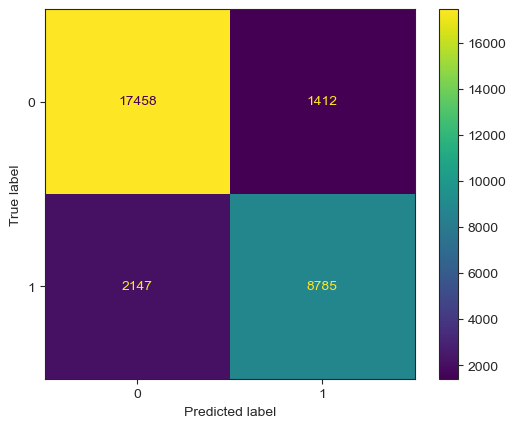

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)

In [52]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(best_xgb, open('classificationmodel.pkl', 'wb'))